## Setup Instructions

**First-time setup:** This notebook requires the `safedriver-iq` package to be installed. Run the setup cell below to check and install if needed.

**Kernel:** Make sure you've selected the Python kernel from `~/src/.venv` (or your project's virtual environment).

In [10]:
# Auto-setup: Check and install package if needed
import sys
import subprocess
import os
from pathlib import Path

# Get the project root directory by searching for setup.py
current_path = Path.cwd()
project_root = None

# Search up the directory tree for setup.py
for parent in [current_path] + list(current_path.parents):
    if (parent / 'setup.py').exists():
        project_root = parent
        break

if project_root is None:
    # Fallback: assume we're in notebooks/ and go up one level
    project_root = Path(__file__).parent.parent if '__file__' in dir() else current_path.parent

print(f"📁 Project root: {project_root}")

try:
    # Try importing to check if package is installed
    import data_loader
    print("✓ Package 'safedriver-iq' is already installed and ready to use!")
except ImportError:
    print("⚠ Package not found. Installing 'safedriver-iq' in editable mode...")
    print(f"  Installing from: {project_root}")
    
    # Install the package in editable mode
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "-e", str(project_root)],
        capture_output=True,
        text=True
    )
    
    if result.returncode == 0:
        print("✓ Installation successful! You can now run the rest of the notebook.")
    else:
        print("✗ Installation failed. Please run manually:")
        print(f"  pip install -e {project_root}")
        print(f"\nError: {result.stderr}")

📁 Project root: /home/samaresh/src/safedriver-iq
✓ Package 'safedriver-iq' is already installed and ready to use!


# SafeDriver-IQ: Data Exploration

**Notebook 1: Initial Data Exploration**

This notebook explores the CRSS (Crash Report Sampling System) dataset to understand:
- Data structure and quality
- VRU crash patterns
- Key features and distributions
- Data preparation for modeling

In [11]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import CRSSDataLoader
from preprocessing import CrashPreprocessor
from visualization import CrashVisualizer

# Settings
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load CRSS Data

Load data from the CRSS_Data directory for years 2016-2023.

In [12]:
# Initialize data loader
# Use absolute path to CRSS_Data directory
data_dir = os.path.join(str(project_root), 'CRSS_Data')

print(f"📁 Looking for data in: {data_dir}")
if os.path.exists(data_dir):
    print("✓ Data directory found!")
    loader = CRSSDataLoader(data_dir=data_dir, years=list(range(2016, 2024)))
    print("✓ Data loader initialized")
    print("Loading CRSS data...")
    print("This may take several minutes...\n")
else:
    print("✗ Data directory not found!")
    print(f"Expected location: {data_dir}")
    print("\nPlease ensure the CRSS_Data directory is in the project root.")

📁 Looking for data in: /home/samaresh/src/safedriver-iq/CRSS_Data
✓ Data directory found!
✓ Data loader initialized
Loading CRSS data...
This may take several minutes...



In [13]:
# Load accident data for a single year first (to check structure)
sample_accident = loader.load_accident_data(2023)

print(f"Sample accident data (2023): {len(sample_accident):,} records")
print(f"Columns: {len(sample_accident.columns)}")
print("\nFirst few columns:")
print(sample_accident.columns[:20].tolist())

INFO:data_loader:Loading accident data for 2023 from accident.csv


Sample accident data (2023): 50,103 records
Columns: 80

First few columns:
['CASENUM', 'PSU', 'PSU_VAR', 'PSUSTRAT', 'REGION', 'REGIONNAME', 'URBANICITY', 'URBANICITYNAME', 'STRATUM', 'STRATUMNAME', 'PJ', 'WEIGHT', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERMVIT', 'MONTH', 'MONTHNAME']


In [14]:
# Load complete dataset (all years, all files)
datasets = loader.load_complete_dataset()

print("\n=== Dataset Summary ===")
for name, df in datasets.items():
    print(f"\n{name.upper()}:")
    print(f"  Records: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Years: {sorted(df['YEAR'].unique())}")
    print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

INFO:data_loader:Loading complete CRSS dataset...
INFO:data_loader:Loading accident data for 2016 from ACCIDENT.CSV
INFO:data_loader:Loading accident data for 2017 from ACCIDENT.CSV
INFO:data_loader:Loading accident data for 2018 from ACCIDENT.csv
INFO:data_loader:Loading accident data for 2019 from accident.CSV
INFO:data_loader:Loading accident data for 2020 from accident.csv
INFO:data_loader:Loading accident data for 2021 from accident.csv
INFO:data_loader:Loading accident data for 2022 from accident.csv
INFO:data_loader:Loading accident data for 2023 from accident.csv
INFO:data_loader:Combined accident data: 267,418 records from 8 years
INFO:data_loader:Loading vehicle data for 2016 from VEHICLE.CSV
INFO:data_loader:Loading vehicle data for 2017 from VEHICLE.CSV
INFO:data_loader:Loading vehicle data for 2018 from VEHICLE.csv
INFO:data_loader:Loading vehicle data for 2019 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2020 from vehicle.csv
INFO:data_loader:Loading vehicle


=== Dataset Summary ===

ACCIDENT:
  Records: 267,418
  Columns: 91
  Years: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
  Memory: 681.9 MB

VEHICLE:
  Records: 469,443
  Columns: 191
  Years: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
  Memory: 2993.0 MB

PERSON:
  Records: 655,675
  Columns: 120
  Years: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
  Memory: 2480.8 MB

PBTYPE:
  Records: 25,519
  Columns: 56
  Years: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
  Memory: 46.8 MB


## 2. Data Quality Assessment

Check for missing values, data types, and quality issues.

In [15]:
# Initialize preprocessor
preprocessor = CrashPreprocessor()

# Check quality for each dataset
for name, df in datasets.items():
    print(f"\n{'='*60}")
    quality_metrics = preprocessor.check_data_quality(df, name)
    print(f"{'='*60}")

INFO:preprocessing:
=== Data Quality Report: accident ===


INFO:preprocessing:Total records: 267,418
INFO:preprocessing:Duplicate records: 0
INFO:preprocessing:Total missing values: 2,930,617
INFO:preprocessing:
=== Data Quality Report: vehicle ===


INFO:preprocessing:Total records: 469,443
INFO:preprocessing:Duplicate records: 0
INFO:preprocessing:Total missing values: 11,392,386
INFO:preprocessing:
=== Data Quality Report: person ===


INFO:preprocessing:Total records: 655,675
INFO:preprocessing:Duplicate records: 0
INFO:preprocessing:Total missing values: 9,150,826
INFO:preprocessing:
=== Data Quality Report: pbtype ===
INFO:preprocessing:Total records: 25,519
INFO:preprocessing:Duplicate records: 0
INFO:preprocessing:Total missing values: 25,837


In [16]:
# Examine accident data structure
accident_df = datasets['accident']

print("Accident Data Sample:")
print(accident_df.head())

Accident Data Sample:
          version https://git-lfs.github.com/spec/v1  YEAR  CASENUM  STRATUM  \
0  oid sha256:cf7ffe49dc7b862fbbcde60aebc4be158d6...  2016      NaN      NaN   
1                                       size 6474134  2016      NaN      NaN   
2  oid sha256:7caadb1ca720b86150f839fc89370dfbe90...  2017      NaN      NaN   
3                                       size 7656361  2017      NaN      NaN   
4  oid sha256:085736a9e9101c300c8472ef0391beacdbb...  2018      NaN      NaN   

  STRATUMNAME  REGION REGIONNAME  PSU  PJ  PSU_VAR  URBANICITY URBANICITYNAME  \
0         NaN     NaN        NaN  NaN NaN      NaN         NaN            NaN   
1         NaN     NaN        NaN  NaN NaN      NaN         NaN            NaN   
2         NaN     NaN        NaN  NaN NaN      NaN         NaN            NaN   
3         NaN     NaN        NaN  NaN NaN      NaN         NaN            NaN   
4         NaN     NaN        NaN  NaN NaN      NaN         NaN            NaN   

   VE_TOTA

In [17]:
# Check data types
print("Data Types:")
print(accident_df.dtypes.value_counts())

print("\nSample numeric columns:")
print(accident_df.select_dtypes(include=[np.number]).columns[:10].tolist())

Data Types:
float64    52
object     38
int64       1
Name: count, dtype: int64

Sample numeric columns:
['YEAR', 'CASENUM', 'STRATUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'VE_TOTAL', 'VE_FORMS']


## 3. VRU Crash Analysis

Focus on Vulnerable Road User (pedestrian, bicyclist) crashes.

In [18]:
# Get VRU crashes
person_df = datasets['person']

print("Person Type Distribution:")
print(person_df['PER_TYP'].value_counts())

# Filter for VRUs
vru_persons = person_df[person_df['PER_TYP'].isin([5, 6])]
print(f"\nTotal VRU persons: {len(vru_persons):,}")
print(f"  Pedestrians (PER_TYP=5): {(vru_persons['PER_TYP']==5).sum():,}")
print(f"  Bicyclists (PER_TYP=6): {(vru_persons['PER_TYP']==6).sum():,}")

Person Type Distribution:
PER_TYP
1.0     468311
2.0     159364
5.0      14591
6.0       9404
3.0       2195
8.0        921
11.0       259
12.0       210
9.0        119
4.0         97
13.0        67
10.0        66
7.0         61
19.0         4
Name: count, dtype: int64

Total VRU persons: 23,995
  Pedestrians (PER_TYP=5): 14,591
  Bicyclists (PER_TYP=6): 9,404


In [19]:
# Get unique VRU crashes
vru_case_ids = vru_persons['CASENUM'].unique()
print(f"Unique VRU crashes: {len(vru_case_ids):,}")

# Filter accident data for VRU crashes
vru_accidents = accident_df[accident_df['CASENUM'].isin(vru_case_ids)]
print(f"VRU accident records: {len(vru_accidents):,}")

Unique VRU crashes: 23,194
VRU accident records: 23,194


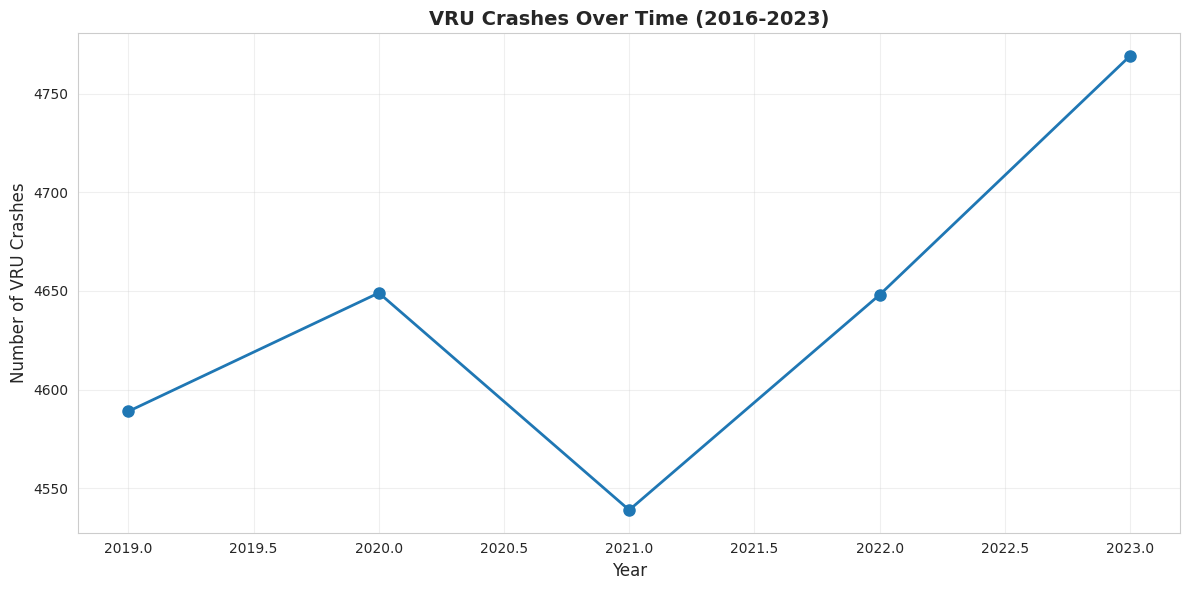


VRU Crashes by Year:
YEAR
2019    4589
2020    4649
2021    4539
2022    4648
2023    4769
Name: count, dtype: int64


In [20]:
# VRU crashes by year
vru_by_year = vru_accidents['YEAR'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(vru_by_year.index, vru_by_year.values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of VRU Crashes', fontsize=12)
plt.title('VRU Crashes Over Time (2016-2023)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVRU Crashes by Year:")
print(vru_by_year)

## 4. Key Feature Exploration

Explore important features for safety modeling.

In [21]:
# Check available features in accident data
print("Available columns in accident data:")
print(f"Total: {len(accident_df.columns)}")
print("\nColumn names:")
for i, col in enumerate(accident_df.columns, 1):
    print(f"{i:3d}. {col}", end="   ")
    if i % 4 == 0:
        print()

Available columns in accident data:
Total: 91

Column names:
  1. version https://git-lfs.github.com/spec/v1     2. YEAR     3. CASENUM     4. STRATUM   
  5. STRATUMNAME     6. REGION     7. REGIONNAME     8. PSU   
  9. PJ    10. PSU_VAR    11. URBANICITY    12. URBANICITYNAME   
 13. VE_TOTAL    14. VE_FORMS    15. PVH_INVL    16. PEDS   
 17. PERMVIT    18. PERNOTMVIT    19. NUM_INJ    20. NUM_INJNAME   
 21. MONTH    22. MONTHNAME    23. YEARNAME    24. DAY_WEEK   
 25. DAY_WEEKNAME    26. HOUR    27. HOURNAME    28. MINUTE   
 29. MINUTENAME    30. HARM_EV    31. HARM_EVNAME    32. ALCOHOL   
 33. ALCOHOLNAME    34. MAX_SEV    35. MAX_SEVNAME    36. MAN_COLL   
 37. MAN_COLLNAME    38. RELJCT1    39. RELJCT1NAME    40. RELJCT2   
 41. RELJCT2NAME    42. TYP_INT    43. TYP_INTNAME    44. WRK_ZONE   
 45. WRK_ZONENAME    46. REL_ROAD    47. REL_ROADNAME    48. LGT_COND   
 49. LGT_CONDNAME    50. WEATHER1    51. WEATHER1NAME    52. WEATHER2   
 53. WEATHER2NAME    54. WEATHER    55

VRU Crashes by Hour of Day:


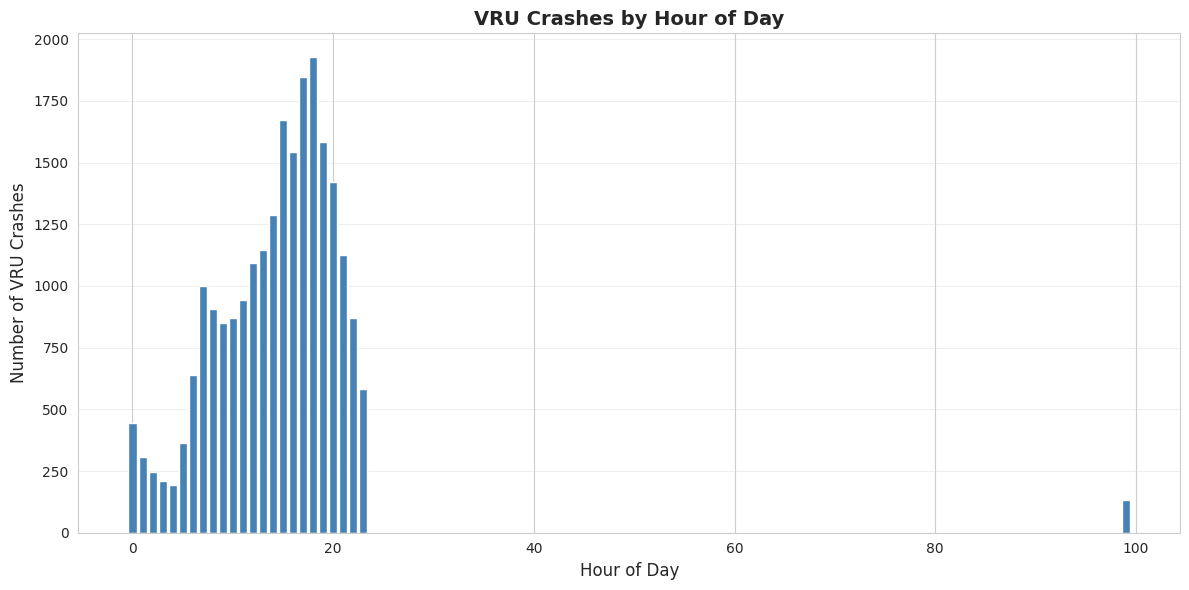

In [22]:
# Temporal features
if 'HOUR' in vru_accidents.columns:
    print("VRU Crashes by Hour of Day:")
    hour_dist = vru_accidents['HOUR'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.bar(hour_dist.index, hour_dist.values, color='steelblue')
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Number of VRU Crashes', fontsize=12)
    plt.title('VRU Crashes by Hour of Day', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

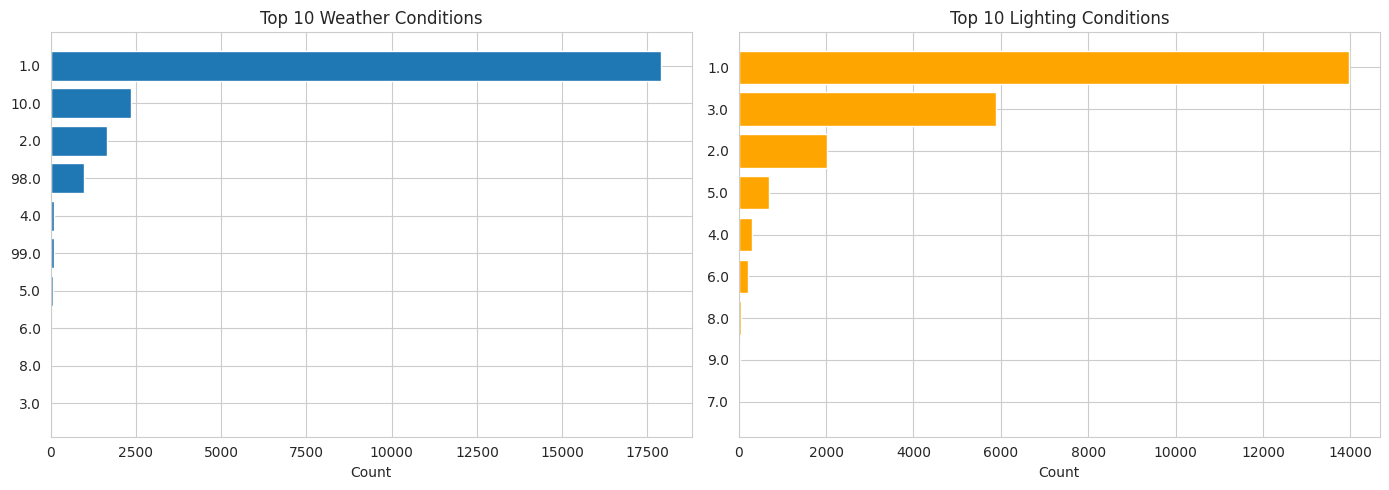

In [23]:
# Weather and lighting conditions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'WEATHER' in vru_accidents.columns:
    weather_dist = vru_accidents['WEATHER'].value_counts().head(10)
    axes[0].barh(range(len(weather_dist)), weather_dist.values)
    axes[0].set_yticks(range(len(weather_dist)))
    axes[0].set_yticklabels(weather_dist.index)
    axes[0].set_xlabel('Count')
    axes[0].set_title('Top 10 Weather Conditions')
    axes[0].invert_yaxis()

if 'LGT_COND' in vru_accidents.columns:
    light_dist = vru_accidents['LGT_COND'].value_counts().head(10)
    axes[1].barh(range(len(light_dist)), light_dist.values, color='orange')
    axes[1].set_yticks(range(len(light_dist)))
    axes[1].set_yticklabels(light_dist.index)
    axes[1].set_xlabel('Count')
    axes[1].set_title('Top 10 Lighting Conditions')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Injury Severity Analysis

Examine injury outcomes for VRU crashes.

VRU Injury Severity Distribution:
INJ_SEV
0.0     242
1.0    8089
2.0    9938
3.0    4237
4.0    1251
5.0     176
9.0      62
Name: count, dtype: int64


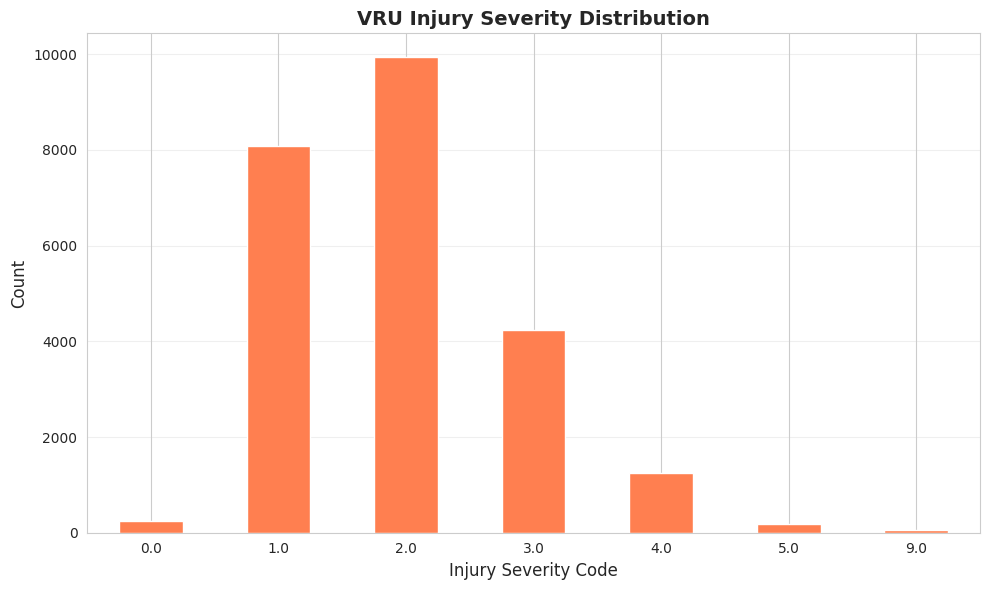


Fatal VRU injuries: 1,251
Fatality rate: 5.21%


In [24]:
# Injury severity for VRU persons
if 'INJ_SEV' in vru_persons.columns:
    print("VRU Injury Severity Distribution:")
    injury_dist = vru_persons['INJ_SEV'].value_counts().sort_index()
    print(injury_dist)
    
    # Plot
    plt.figure(figsize=(10, 6))
    injury_dist.plot(kind='bar', color='coral')
    plt.xlabel('Injury Severity Code', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('VRU Injury Severity Distribution', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Fatal crashes
    fatal_vru = (vru_persons['INJ_SEV'] == 4).sum()
    print(f"\nFatal VRU injuries: {fatal_vru:,}")
    print(f"Fatality rate: {fatal_vru/len(vru_persons)*100:.2f}%")

## 6. Save Processed Data

Save cleaned data for next notebooks.

In [ ]:
# Save VRU data
print("Saving processed data...")

# Create processed data directory if it doesn't exist
processed_dir = os.path.join(str(project_root), 'data', 'processed')
os.makedirs(processed_dir, exist_ok=True)
print(f"📁 Output directory: {processed_dir}")

# Define output file paths
vru_accidents_path = os.path.join(processed_dir, 'vru_accidents.parquet')
vru_persons_path = os.path.join(processed_dir, 'vru_persons.parquet')
vru_case_ids_path = os.path.join(processed_dir, 'vru_case_ids.csv')

# Save files
vru_accidents.to_parquet(vru_accidents_path, index=False)
vru_persons.to_parquet(vru_persons_path, index=False)
pd.Series(vru_case_ids).to_csv(vru_case_ids_path, index=False, header=['CASENUM'])

print("✓ Saved VRU accidents")
print("✓ Saved VRU persons")
print("✓ Saved VRU case IDs")

print("\nData exploration complete!")

Saving processed data...


OSError: Cannot save file into a non-existent directory: '../data/processed'

## Summary

### Key Findings:
1. **Dataset Size**: Successfully loaded 8 years of CRSS data (2016-2023)
2. **VRU Crashes**: Identified thousands of VRU crashes involving pedestrians and bicyclists
3. **Data Quality**: Assessed missing values and data completeness
4. **Key Features**: Identified temporal, environmental, and location features
5. **Injury Patterns**: Analyzed severity distributions for VRU crashes

### Next Steps:
- **Notebook 2**: Feature engineering for safety modeling
- **Notebook 3**: Crash pattern clustering
- **Notebook 4**: Inverse safety model training
- **Notebook 5**: Good driver profile extraction